# Temperatures from Electric Fields and Polarizations
The following notebook walks through the procedure for calcuating the steady-state temperture rise from a 10 nm radius sphere at its LSP resonance. This procedure, is general enough that one may make arbitary shape files with multiple, different shaped nanoparticles. (Note that the other approach, in folder `input_acs`, will only work for particles of identical shape.) 

The approach used herein uses the electric fields and polarizations of each dipole to calculate the absorption cross-section per particle $j$, according to:

$$
\sigma_{\textrm{abs}, j} = 4 \pi k \sum_{j=1}^N \Big ( \textrm{Im} \big [ \textbf{P}_j \cdot \textbf{E}_j^* \big ] - \frac{2}{3} k^3 \textbf{P}_j \cdot \textbf{P}_j^* \Big ) 
$$

In order to run this notebook, you should install the version of Draine's discrete dipole approximation in the repo [MasielloGroup/g-dda](http://github.com/MasielloGroup/g-dda). It is not required that you use this version, however it has currently been modified to create the appropriate output file. (To install `g-dda`, you must have a Fortran compiler installed.)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Optical calculation
The first step in calculating the temperture resulting from the nonradiative decay of the LSP is to run an optical calculation to determine, in this procedure, the electric fields and polarizations of each dipole in the system. This can be solved for by running a modified version of Draine's Discrete Dipole Approximation linked above. To make this calculation at the LSP resonance, the first step is to run a spectrum to find the wavelength of this resonance. 

### Step 1: Define shape and make directories
Set the lattice spacing and radius of the sphere, and make the input files in the following lines. 

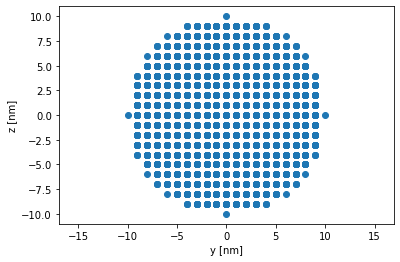

In [12]:
from make_sphere import Generate_Sphere

lat_space = 1 # lattice spacing in nm
radius = 10 # radius of sphere in nm

gen_shape = Generate_Sphere(lat_space=lat_space, radius_nm=radius)
gen_shape.write_shape() # write the shape to a file
gen_shape.plot_shape() # plots the shape

In [13]:
# Delete any previously run folders
from make_dirs import make_directories
import shutil
import glob

files = glob.glob('*um')
for f in files:
    shutil.rmtree(f)

### Step 2: Make directories
After the shape is made, edit ddscat.par normally. (I haven't made anything fancy yet, so you'll have to go into that file and edit it by hand for now. Once you've edited ddscat.par appropriately, the function `make_directories` will make `num` number of folders which will contain your scattering calculations for each wavelength / energy.

In [14]:
from make_dirs import make_directories

make_directories(intermsof='um', # eV or nm, only eV for now
                 start=0.4, # start spectrum at 2.0 eV
                 finish=0.7, # end spectrum at 3.0 eV
                 num=21 # 50 points in between 
                )

### Step 2.5: Edit `ddscat.par`
Make sure the file `ddscat.par` is updated as described in the `README.md`. The vacuum wavelength does not need to be updated, as it will be changed in the scripts below to create a spectrum. 

### Step 3: Run scattering calculation
Change this path to wherever you've kept the `g-dda` executables. This will run all the `num` number of calculations. On a laptop, it should take less than a minute. 

In [15]:
%%bash
for i in *um ; do
    cd $i
    ../../../../git_repos_masiello/g-dda/source_code/ddscat &> output.txt
    cd ../
done

In [16]:
%%bash
# Collect all the files and write it to a file named Spectrum
for i in *um ;do
    cd $i
    cp qtable temp
    sed -i -e "1,14d" temp
    cat temp >>../Spectrum
    rm temp
    cd ../
done

### Step 4: Plot spectrum and find resonance

0.505


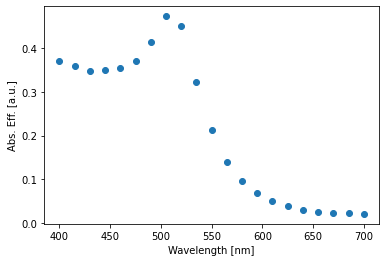

In [17]:
spectrum = np.loadtxt('Spectrum')
plt.scatter(spectrum[:,1]*1000, spectrum[:,3])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Abs. Eff. [a.u.]')
idx = np.where(spectrum[:,3] == max(spectrum[:,3]))
max_wave = np.round(spectrum[idx,1][0][0],3)
print(max_wave)

### Step 4.5: Edit `var.par`
Edit the file, `var.par` according to the system parameters you'd like to set. A description of the parameters in the file can be found in the `README.md`.


### Step 5: Copy inputs and run t-dda
Once you've identified the maximum wavelength / energy, or the wavelength / energy you'd like to run the temperature calculation at, copy those files to a new directory and run `t-dda`. For the above specifications, `t-dda` should run on a laptop in less than a minute.


In [21]:
%%bash -s "$max_wave" 
cp $1_um/tdda_input_w000_ddscat.par tdda_input # Copy files from the wavelength of maximum absorption
../../source_code/Lattice_Diffusion ../../lattice_greenfunction/Green_grid100.txt var.par tdda_input temp.out


### Step 6: Plot the temperature maps
`t-dda` is hardcoded to calculate the temperatures of all the discrete dipoles, as well as any points along the plane specified in the last line of `var.par`. We will plot this plane as a 2D image, or as a 1D slice in the codes below. 

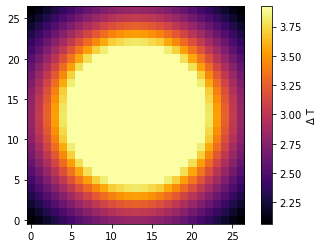

In [22]:
temp_data = np.loadtxt('temp.out')
idx = np.where(temp_data[:,0] == -6)
DS = 1
y = temp_data[idx,1][0]*DS
z = temp_data[idx,2][0]*DS
T = temp_data[idx,3][0]

idx_sort = np.lexsort((y, z))
new_y = y[idx_sort]
new_z = z[idx_sort]
new_temps = T[idx_sort]
y_wind = int(max(y/DS) - min(y/DS) + 1); z_wind = int(max(z/DS) - min(z/DS) + 1)
temp_grid = new_temps.reshape(z_wind, y_wind, order='c')
plt.imshow(temp_grid,origin='lower',cmap='inferno')
plt.colorbar(label='$\Delta$ T')

Temp. of metal: 3.92 K


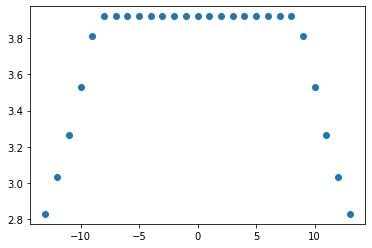

In [23]:
temp_data = np.loadtxt('temp.out')
idx = np.where((temp_data[:,0] == -6) & (temp_data[:,1] == 0 ))
DS = 1
y = temp_data[idx,1][0]*DS
z = temp_data[idx,2][0]*DS
T = temp_data[idx,3][0]
plt.scatter(z, T)
print('Temp. of metal:', np.round(max(T),2), 'K')